<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/Seq_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title rohanpandey WISDM
# https://github.com/rohanpandey/Analysis--WISDM-Smartphone-and-Smartwatch-Activity/blob/master/dataset_creation.ipynb
! wget https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm-dataset.zip

import os
import glob
import pandas as pd

folder1=glob.glob("wisdm-dataset/raw/*")
# print(folder1)
column_names = ['ID', 'activity','timestamp','x','y','z']
overall_dataframe=pd.DataFrame(columns = column_names)
for subfolder in folder1:
    parent_dir = "./processed/"
    path = os.path.join(parent_dir, subfolder.split('\\')[-1])
    if not os.path.exists(path): os.makedirs(path)
    folder2=glob.glob(subfolder+"/*")
    for subsubfolder in folder2:
        activity_dataframe = pd.DataFrame(columns = column_names)
        subfolder_path = os.path.join(path, subsubfolder.split('/')[-1])
        if not os.path.exists(subfolder_path): os.makedirs(subfolder_path)
        files=glob.glob(subsubfolder+"/*")
        for file in files:
            # print(file)
            df = pd.read_csv(file, sep=",",header=None)
            df.columns = ['ID','activity','timestamp','x','y','z']
            # activity_dataframe=activity_dataframe.append(df)
            activity_dataframe = pd.concat([activity_dataframe, df], ignore_index=True)

        activity_dataframe['z']=activity_dataframe['z'].str[:-1]
        # activity_dataframe['meter']=subsubfolder.split('/')[-1]
        # activity_dataframe['device']=subfolder.split('/')[-1]
        activity_dataframe.to_csv(subfolder_path+'/data.csv',index=False)


In [2]:
# @title wisdm dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd

# /content/processed/wisdm-dataset/raw/phone/accel/data.csv
# /content/processed/wisdm-dataset/raw/watch/gyro/data.csv

class BufferDataset(Dataset):
    def __init__(self):
        # df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
        df_keep = pd.read_csv("/content/processed/wisdm-dataset/raw/watch/accel/data.csv")

        user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
        self.data = [[d.to_numpy(), a] for a, d in user_acts.items()]
        self.act_dict = {i: act for i, act in enumerate(df_keep['activity'].unique())}
        self.act_invdict = {v: k for k, v in self.act_dict.items()} # {'A': 0, 'B': 1, ...

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, id_act = self.data[idx]
        id_act = self.process(id_act)
        return torch.tensor(x[:3500]), id_act # 3567

    def process(self, id_act):
        return int(id_act[0]), self.act_invdict[id_act[1]]

    def transform(self, act_list): # rand resize crop, rand mask # https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html
        act_list = np.array(act_list)
        try: hr, temp, heart= zip(*act_list)
        except ValueError: print('err:',act_list)
        kind = 'nearest' if len(act_list)>self.seq_len/.7 else 'linear'
        temp_interpolator = scipy.interpolate.interp1d(hr, temp, kind=kind) # linear nearest quadratic cubic
        heart_interpolator = scipy.interpolate.interp1d(hr, heart, kind=kind) # linear nearest quadratic cubic
        hr_ = np.sort(np.random.uniform(hr[0], hr[-1], round(self.seq_len*random.uniform(1,1/.7))))
        temp_, heart_ = temp_interpolator(hr_), heart_interpolator(hr_)
        act_list = list(zip(hr_, temp_, heart_))

        idx = torch.randint(len(act_list)-self.seq_len+1, size=(1,))
        # return act_list[idx: idx+self.seq_len]
        act_list = act_list[idx: idx+self.seq_len]

        # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # # act_list[mask] = self.pad[0]
        # act_list = [self.pad[0] if m else a for m,a in zip(mask, act_list)]
        return act_list

    def add(self, episode):
        self.data.append(episode)

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
# user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
# dataset = [[d.to_numpy(), a] for a, d in user_acts.items()]


train_data = BufferDataset() # one line of poem is roughly 50 characters

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.7 * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
# train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
# test_loader = DataLoader(train_data, sampler=valid_sampler, batch_size=batch_size, num_workers=2, drop_last=True)
train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)


In [3]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.n_heads = dim, n_heads
        d_head = dim//n_heads
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))
        # self.rope = RoPE(d_head, seq_len=512, base=10000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        self.scale = d_head**-.5

    def forward(self, x): # [b,t,d]
        q,k,v = self.qkv(x).unflatten(-1, (self.n_heads,-1)).transpose(1,2).chunk(3, dim=-1) # [b, t, n_heads, d_head] -> [b, n_heads, t, d_head]
        # q, k = self.rope(q), self.rope(k)
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t, d_head]
        # print('SelfAttn', x.shape)
        x = x.transpose(1,2).flatten(2)
        return self.lin(x)

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, mult=4, drop=0.):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model, elementwise_affine=False) # LayerNorm RMSNorm
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), act, nn.Dropout(drop), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(ff_dim), act, nn.Dropout(drop), zero_module(nn.Linear(ff_dim, d_model))
        )

    def forward(self, x): # [batch, seq_len, d_model]
        # print('attnblk fwd',x.shape)
        x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(self.norm2(x)))
        return x


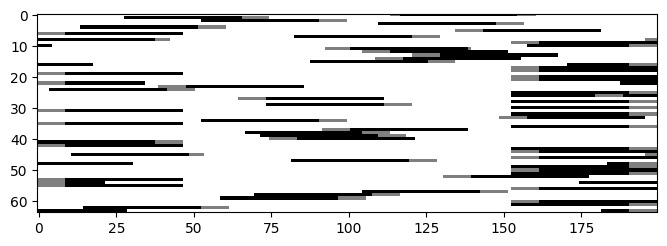

In [12]:
# @title simplex
# !pip install -q opensimplex
import opensimplex
import numpy as np
import torch
import matplotlib.pyplot as plt

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=[1,.5]):
    i = np.linspace(0, chaos[0], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)
    # trunc_normal = torch.fmod(torch.randn(2)*.3,1)/2 + .5
    # print(trunc_normal)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]
    # ctx_mask_scale = trunc_normal[0] * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    # trg_mask_scale = trunc_normal[1] * (trg_scale[1] - trg_scale[0]) + trg_scale[0]

    ctx_len, trg_len = int(seq*ctx_mask_scale), int(seq*trg_mask_scale)
    val, trg_index = torch.topk(noise, trg_len, dim=1, sorted=False)
    ctx_len = ctx_len - trg_len

    remove_mask = torch.ones((B,seq), dtype=bool) # [B, S]
    remove_mask.scatter_(1, trg_index, False).flatten()
    ind = torch.arange(seq).unsqueeze(0).repeat(B,1)[remove_mask].reshape(B, -1)

    i = np.linspace(0, chaos[1], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)[remove_mask].reshape(B, -1)
    val, ctx_ind = torch.topk(noise, ctx_len, dim=1, sorted=False)
    ctx_index = ind[torch.arange(B).unsqueeze(-1), ctx_ind]
    return ctx_index, trg_index

b=64
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.7,.8), trg_scale=(.4,.6), B=b, chaos=[3,.5])
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=b, chaos=[1,.5])
ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.8,.9), trg_scale=(.7,.8), B=b, chaos=[1,.5])
mask = torch.zeros(b ,200)
mask[torch.arange(b).unsqueeze(-1), trg_index] = 1
mask[torch.arange(b).unsqueeze(-1), ctx_index] = .5
mask = mask[None,...]
def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# imshow(mask)
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))

# print(index)
# print(index.shape)
# print(mask)
# print(mask.shape)


In [ ]:
trunc_normal = torch.fmod(torch.randn(100),1)/2 + .5
print(trunc_normal)

tensor([0.4075, 0.8762, 0.7514, 0.2137, 0.7609, 0.4488, 0.9301, 0.6824, 0.2306,
        0.0416, 0.5345, 0.2072, 0.2726, 0.8464, 0.1821, 0.6435, 0.1008, 0.5005,
        0.6204, 0.9338, 0.6580, 0.5576, 0.4063, 0.3929, 0.5876, 0.2481, 0.6494,
        0.1944, 0.9617, 0.8610, 0.5882, 0.1805, 0.8120, 0.6265, 0.1962, 0.7703,
        0.7108, 0.4484, 0.6399, 0.5808, 0.9070, 0.8521, 0.8258, 0.4551, 0.0527,
        0.3494, 0.1667, 0.4829, 0.2349, 0.5762, 0.3556, 0.2047, 0.2669, 0.5557,
        0.6850, 0.4638, 0.7767, 0.4705, 0.4847, 0.2944, 0.5512, 0.0012, 0.7335,
        0.3080, 0.5374, 0.4232, 0.6948, 0.9091, 0.3728, 0.8499, 0.5635, 0.8143,
        0.6646, 0.2978, 0.6630, 0.5456, 0.2028, 0.0696, 0.7285, 0.4377, 0.7755,
        0.7153, 0.5771, 0.0754, 0.1795, 0.7382, 0.1254, 0.0416, 0.1422, 0.5820,
        0.9830, 0.5813, 0.2172, 0.8218, 0.9785, 0.9753, 0.3840, 0.2212, 0.2657,
        0.5348])


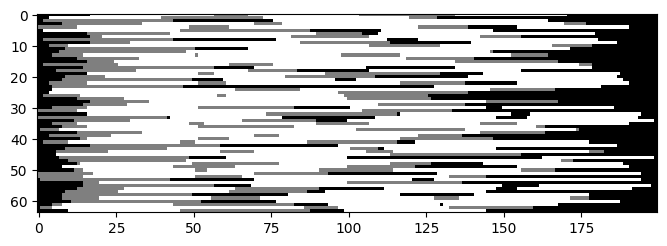

In [ ]:
# @title ijepa multiblock 1d
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import torch

class MaskCollator(object):
    def __init__(self, length=200,
        enc_mask_scale=(0.2, 0.8), pred_mask_scale=(0.2, 0.8),
        nenc=1, npred=2, min_keep=4, allow_overlap=False):
        super().__init__()
        self.length = length
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks

    def _sample_block_size(self, scale):
        _rand = torch.rand(1).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.length * mask_scale) # num patches to keep
        # -- Sample block aspect-ratio
        # -- Compute block height and width (given scale and aspect-ratio)
        l = max_keep#int(round(math.sqrt(max_keep * aspect_ratio)))
        while l >= self.length: l -= 1 # crop mask to be smaller than img
        return l

    def _sample_block_mask(self, length, acceptable_regions=None):
        l = length
        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            left = torch.randint(0, self.length - l, (1,))
            mask = torch.zeros(self.length, dtype=torch.int32)
            mask[left:left+l] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones(self.length, dtype=torch.int32)
        mask_complement[left:left+l] = 0
        # --
        return mask, mask_complement

    def __call__(self, B):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        p_size = self._sample_block_size(scale=self.pred_mask_scale)
        e_size = self._sample_block_size(scale=self.enc_mask_scale)

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.length
        min_keep_enc = self.length
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)
        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)
        return collated_masks_enc, collated_masks_pred

batch=64
length=200
mask_collator = MaskCollator(length=length, enc_mask_scale=(.85, 1.), pred_mask_scale=(.15, .2),
        nenc=1, npred=4, min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)

collated_masks_enc, collated_masks_pred = mask_collator(batch)
context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
# print(context_indices.shape, trg_indices.shape)


# plt.pcolormesh(mask)
b=64
mask = torch.zeros(batch ,length)
mask[torch.arange(batch).unsqueeze(-1), trg_indices] = 1
mask[torch.arange(batch).unsqueeze(-1), context_indices] = .5
mask = mask[None,...]
def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# imshow(mask)
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))



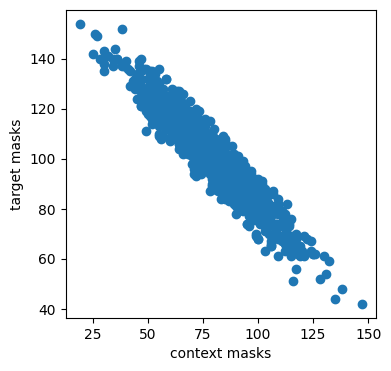

In [ ]:
plt.rcParams["figure.figsize"] = (4,4)
# plt.plot(ttc,ttt)
plt.scatter(ttc,ttt)
plt.xlabel('context masks')
plt.ylabel('target masks')

plt.show()

35.525 149.368


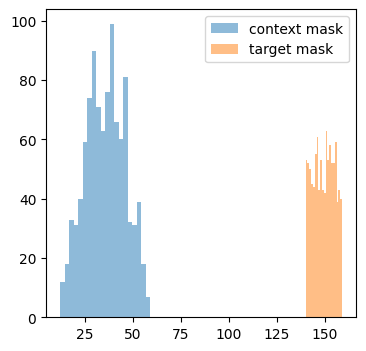

In [14]:
ttc=[]
ttt=[]
def mean(x): return sum(x)/len(x)

for i in range(1000):
    # collated_masks_enc, collated_masks_pred = mask_collator(1)
    # context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
    # context_indices, trg_indices = simplexmask1d(seq=200, ctx_scale=(.8,1), trg_scale=(.2,.8), B=1, chaos=[3,.5])
    context_indices, trg_indices = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=1, chaos=[1,.5])
    ttc.append(context_indices.shape[-1])
    ttt.append(trg_indices.shape[-1])

print(mean(ttc), mean(ttt))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)
plt.hist(ttc, bins=20, alpha=.5, label='context mask')
plt.hist(ttt, bins=20, alpha=.5, label='target mask')
plt.legend()
plt.show()

In [5]:
# @title TransformerModel/Predictor
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerPredictor(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, d_hid=None, nlayers=1, drop=0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.randn(1,1,d_model)*0.02) # randn zeros
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_enc(context_indices)
        # print("Trans pred",x.shape, self.pos_emb[0,context_indices].shape)
        x = x + self.pos_emb[0,context_indices]
        # print('pred fwd', self.pos_emb[:,context_indices].shape)

        # pred_tokens = self.cls * self.pos_enc(trg_indices) # [M, num_trg_toks, d_model]
        pred_tokens = self.cls + self.pos_emb[0,trg_indices]
        # print("pred fwd", x.shape, pred_tokens.shape)
        x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
        out = self.transformer(x)

        out = self.norm(out)
        out = out[:,seq:] # [batch, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop=0):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0):
        super().__init__()
        # patch_size=32
        self.embed = nn.Sequential(
            # # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            # # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model, patch_size, patch_size), # like patch
            )
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000), requires_grad=False)#.unsqueeze(0)
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        # try: print("Trans fwd",x.shape, context_indices.shape)
        # except: print("Trans fwd noind",x.shape)
        # x = self.pos_enc(x)
        x = x + self.pos_emb[:,:x.shape[1]]
        if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]

        # print("TransformerModel",x.shape)
        x = self.transformer(x)
        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out


batch, seq_len, d_model = 4,3500,16
in_dim = 3
patch_size=32
model = TransformerModel(patch_size, in_dim, d_model, n_heads=4, nlayers=10, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # # print(out)
# model = TransformerPredictor(in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1).to(device)
# out = model(out)
# print(out.shape)



38128
torch.Size([4, 110, 16])


In [15]:
# @title SeqJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4):
        super().__init__()
        if out_dim is None: out_dim = d_model
        self.patch_size = 32
        self.student = TransformerModel(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, n_heads=4, nlayers=1, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)
        # self.transform = RandomResizedCrop1d(3500, scale=(.8,1.))

    def loss(self, x): # [batch, T, 3]
        batch, seq, dim = x.shape
        # target_mask = multiblock(seq//self.patch_size, min_s=.2, max_s=.3, M=4, B=1).any(1).squeeze(1) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # # target_mask = randpatch(seq//self.patch_size, mask_size=8, gamma=.9).unsqueeze(0) # 8.9 [seq]

        # print(target_mask.shape, x.shape)
        # context_mask = ~multiblock(seq//self.patch_size, min_s=.85, max_s=1, M=1, B=1).squeeze(1)|target_mask # og .85,1.M1 # [1, seq], True->Mask
        # context_mask = torch.zeros((1,seq//self.patch_size), dtype=bool)|target_mask # [1,h,w], True->Mask

        context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.85,1), trg_scale=(.7,.8), B=batch, chaos=[3,.5])
        # context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.8,.9), trg_scale=(.7,.8), B=batch, chaos=[1,.5])
        # context_indices, trg_indices = simplexmask1d(seq//self.patch_size, ctx_scale=(.8,1), trg_scale=(.2,.8), B=batch, chaos=[1,.5])
        # print(context_indices.shape, trg_indices.shape)

        # context_indices = context_indices.repeat(batch,1)
        # trg_indices = trg_indices.repeat(batch,1)
        # context_mask = ~context_mask|target_mask # [1,]
        # context_indices = (~context_mask).nonzero()[:,1].unsqueeze(0).repeat(batch,1)
        # # print(trg_indices.shape, context_indices.shape)
        # # print(context_mask.shape,target_mask.shape, x.shape)
        # target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # # # target_mask, context_mask = target_mask.repeat(batch,1), context_mask.repeat(batch,1)
        # # x_ = x * F.adaptive_avg_pool1d((~context_mask).float(), x.shape[1]).unsqueeze(-1) # zero masked locations

        # context_indices = (~context_mask).nonzero()[:,1].unflatten(0, (batch,-1)) # int idx [num_context_toks] , idx of context not masked
        # trg_indices = target_mask.nonzero()[:,1].unflatten(0, (batch,-1)) # int idx [num_trg_toks] , idx of targets that are masked


        # mask_collator = MaskCollator(length=seq//self.patch_size, enc_mask_scale=(.85,1), pred_mask_scale=(.15,.2), nenc=1, npred=4, min_keep=4, allow_overlap=False)
        # collated_masks_enc, collated_masks_pred = mask_collator(batch) # idx of ctx, idx of masked trg
        # # # collated_masks_enc, collated_masks_pred = mask_collator(1) # idx of ctx, idx of masked trg
        # context_indices, trg_indices = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]
        # # # # zero_mask = torch.zeros(batch ,seq//self.patch_size, device=device)
        # # # # zero_mask[torch.arange(batch).unsqueeze(-1), context_indices] = 1
        # # # zero_mask = torch.zeros(1 ,seq//self.patch_size, device=device)
        # # # zero_mask[:, context_indices] = 1
        # # # x_ = x * F.adaptive_avg_pool1d(zero_mask, x.shape[1]).unsqueeze(-1) # zero masked locations
        # # # context_indices, trg_indices = context_indices.repeat(batch,1), trg_indices.repeat(batch,1)


        # print('x_',x_.shape, context_indices.shape, trg_indices.shape)

        sx = self.student(x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # print('seq_jepa loss sx',sx.shape)
        sy_ = self.predicter(sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        sy_ = F.layer_norm(sy_, (sy_.size(-1),))
        with torch.no_grad():
            sy = self.teacher(x.detach()) # [batch, num_trg_toks, out_dim]
            sy = sy[torch.arange(sy.shape[0]).unsqueeze(-1), trg_indices] # [batch, num_context_toks, d_model] # nan bec len(trg_ind)==0 # print('loss sy',torch.isnan(sy).any())
            sy = F.layer_norm(sy, (sy.size(-1),))
        loss = F.mse_loss(sy, sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        sx = self.student(x)
        out = sx.mean(dim=1)
        return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

# 1e-2,1e-3 < 3e-3,1e-3
# patch16 < patch32
# NoPE good but sus


# seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, nlayers=4, n_heads=4).to(device)#.to(torch.float)
seq_jepa = SeqJEPA(in_dim=3, d_model=64, out_dim=16, nlayers=1, n_heads=8).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3) # 1e-3?
# optim = torch.optim.AdamW([{'params': seq_jepa.student.parameters()},
#     {'params': seq_jepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2, 5e-2
    # {'params': seq_jepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3, weight_decay=1e-2)

# https://github.com/facebookresearch/ijepa/blob/main/configs/in1k_vith14_ep300.yaml
# d_model 1024,384
# depth 12,6/12
# wd 5e-2 - 4e-1
# adamw 1e-4 - 1e-3 - 1e-6
# ema 0.996-1

print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.parameters())) # 27584
# print(sum(p.numel() for p in seq_jepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.student.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.teacher.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((24, 3500, in_dim), device=device)
out = seq_jepa.loss(x)
print(out.shape)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16, 18).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': seq_jepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)



109920
torch.Size([])


In [ ]:
# @title TransformerVICReg
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerVICReg(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        act = nn.GELU()
        # patch_size=4
        self.embed = nn.Sequential(
            # nn.Linear(in_dim, d_model), act
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(3,2, 3//2),
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model, patch_size, patch_size), # patch
            )
        self.pos_enc = RoPE(d_model, seq_len=200, base=10000) # 10000
        # self.pos_emb = nn.Parameter(torch.randn(1, 200, d_model))
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=200, base=10000).unsqueeze(0), requires_grad=False)

        self.transformer = nn.Sequential(*[AttentionBlock(d_model, n_heads=n_heads) for _ in range(nlayers)])

        # out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        self.attn_pool = nn.Linear(d_model, 1, bias=False)

        dim_v = d_model * 4
        self.exp = nn.Sequential(
            nn.Linear(out_dim, dim_v), act,
            nn.Linear(dim_v, dim_v), act,
            nn.Linear(dim_v, dim_v, bias=False),
            )

    def forward(self, x): # [b,t,d] / [b,c,h,w]
        # x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c]
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [b,t,d]
        # x = self.embed(x)
        x = self.pos_enc(x)
        # x = x + self.pos_emb[:,:x.shape[1]]

        x = self.transformer(x)

        attn = self.attn_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        out = self.lin(out)
        return out # [seq_len, batch, ntoken]

    def expand(self, x):
        sx = self.forward(x)
        vx = self.exp(sx)
        return vx

batch, seq_len = 4,3500
in_dim, d_model, out_dim=16,64,16
model = TransformerVICReg(in_dim, d_model, out_dim, n_heads=8, nlayers=1, drop=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
# x =  torch.rand((batch, in_dim, 32,32), device=device)
out = model(x)
print(out.shape)


torch.Size([4, 16])


In [ ]:
# @title Violet
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class Violet(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, n_heads=4):
        super().__init__()
        out_dim = out_dim or d_model
        self.student = TransformerVICReg(in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)

        # vicreg
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν

        # self.transform = RandomResizedCrop1d(3500, scale=(.8,1.))

    def loss(self, x): # [batch, T, 3]c/ [b,c,h,w]
        # print(x.shape)
        # self.transform(x)
        vx = self.student.expand(x) # [batch, num_context_toks, out_dim]
        with torch.no_grad(): vy = self.teacher.expand(x.detach()) # [batch, num_trg_toks, out_dim]
        loss = self.vicreg(vx, vy)
        return loss

    def forward(self, x): # [batch, T, 3]
        return self.student(x)

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size, num_features = x.shape

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = self.sim_coeff * repr_loss + self.std_coeff * std_loss + self.cov_coeff * cov_loss
        print("in vicreg ",self.sim_coeff * repr_loss.item() , self.std_coeff * std_loss.item() , self.cov_coeff * cov_loss.item())
        # return loss
        return repr_loss, std_loss, cov_loss

# lr1e-3
# n_heads=8 < 4

in_dim=3
violet = Violet(in_dim, d_model=64, out_dim=16, nlayers=1, n_heads=8).to(device)
voptim = torch.optim.AdamW(violet.parameters(), lr=1e-3) # 1e-3?
# voptim = torch.optim.AdamW([{'params': violet.student.transformer.parameters()},
#     {'params': violet.student.exp.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2
# voptim = torch.optim.AdamW([{'params': violet.student.exp.parameters(), 'lr': 3e-3},
#     {'params': [p for n, p in violet.named_parameters() if 'student.exp' not in n]}], lr=1e-3, weight_decay=1e-2) # default 1e-2

# print(sum(p.numel() for p in violet.parameters() if p.requires_grad)) # 27584


x = torch.rand((2,1000,in_dim), device=device)
loss = violet.loss(x)
# print(out.shape)
print(loss)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16, 18).to(device) # torch/autograd/graph.py RuntimeError: CUDA error: device-side assert triggered CUDA kernel errors
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)



in vicreg  1.9939420276162247e-16 24.746832251548767 1.6621681808715039e-09
(tensor(7.9758e-18, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(0.9899, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6622e-09, device='cuda:0', grad_fn=<AddBackward0>))


In [ ]:
# optim.param_groups[0]['lr'] = 1e-3

In [7]:
# @title RankMe
# RankMe: Assessing the Downstream Performance of Pretrained Self-Supervised Representations by Their Rank jun 2023 https://arxiv.org/pdf/2210.02885
import torch

# https://github.com/Spidartist/IJEPA_endoscopy/blob/main/src/helper.py#L22
def RankMe(Z):
    """
    Calculate the RankMe score (the higher, the better).
    RankMe(Z) = exp(-sum_{k=1}^{min(N, K)} p_k * log(p_k)),
    where p_k = sigma_k (Z) / ||sigma_k (Z)||_1 + epsilon
    where sigma_k is the kth singular value of Z.
    where Z is the matrix of embeddings (N × K)
    """
    # compute the singular values of the embeddings
    # _u, s, _vh = torch.linalg.svd(Z, full_matrices=False)  # s.shape = (min(N, K),)
    # s = torch.linalg.svd(Z, full_matrices=False).S
    s = torch.linalg.svdvals(Z)
    p = s / torch.sum(s, axis=0) + 1e-7
    return torch.exp(-torch.sum(p * torch.log(p)))

# Z = torch.randn(5, 3)
# o = RankMe(Z)
# print(o)


In [8]:
# @title LiDAR stable_ssl next
# https://github.com/rbalestr-lab/stable-ssl/blob/main/stable_ssl/monitors.py#L106

def LiDAR(embeddings, eps=1e-7, delta=1e-3):
    embeddings = embeddings.unflatten(0, (-1,2))
    (local_n, q, d), device = embeddings.shape, embeddings.device

    class_means = embeddings.mean(dim=1) # mu_x
    grand_mean_local = class_means.mean(dim=0) # mu
    # print(embeddings.shape, class_means.shape, grand_mean_local.shape) # [50, 2, 64], [50, 64], [64]

    # local_Sb = torch.zeros(d, d, device=device)
    # local_Sw = torch.zeros(d, d, device=device)


    # print(diff_b.shape, diff_w.shape) # [64,1], [64,1]
    # print(local_Sb.shape, local_Sw.shape) # [64,64], [64,64]

    diff_b = (class_means - grand_mean_local).unsqueeze(-1)
    # print(diff_b.shape)
    # # local_Sb = (diff_b @ diff_b.T).sum()
    local_Sb = (diff_b @ diff_b.transpose(-2,-1)).sum(0)
    # # print(embeddings.shape, class_means.shape)
    diff_w = (embeddings - class_means.unsqueeze(1)).reshape(-1,d,1)
    # # print(diff_w.shape)
    # # local_Sw = (diff_w @ diff_w.T).sum()
    local_Sw = (diff_w @ diff_w.transpose(-2,-1)).sum(0)

    # print(local_Sb.shape, local_Sw.shape)
    S_b = local_Sb / (local_n - 1)
    S_w = local_Sw / (local_n * (q - 1))
    S_w += delta * torch.eye(d, device=device)
    # print(S_w.shape, d)

    eigvals_w, eigvecs_w = torch.linalg.eigh(S_w)
    eigvals_w = torch.clamp(eigvals_w, min=eps)

    invsqrt_w = (eigvecs_w * (1.0 / torch.sqrt(eigvals_w))) @ eigvecs_w.transpose(-1, -2)
    Sigma_lidar = invsqrt_w @ S_b @ invsqrt_w

    # lam, _ = torch.linalg.eigh(Sigma_lidar)
    lam = torch.linalg.eigh(Sigma_lidar)[0]
    # print(lam)
    # lam = torch.clamp(lam, min=0.0)

    p = lam / lam.sum() + eps
    # print(p)
    # p = s / torch.sum(s, axis=0) + 1e-7
    return torch.exp(-torch.sum(p * torch.log(p)))


In [16]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="SeqJEPA", config={"model": "res18",}) # violet

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


closs,█▇▇▅▅▄▅▅▄▅▄▅▃▄▃▄▄▄▄▂▃▃▂▂▂▁▃▂▂▃▃▂▂▂▂▂▂▁▁▁
correct,▁▁▂▃▃▅▃▃▄▅▄▄▄▅▅▇▅▅▆▅▇▅▅▆▅▅█▇▅▅██▇▇▇█▇▇▇▆
lidar,▇▅▅▅▆▆▅▅▄▇▅▅▆▆▅█▇▄▆▆▆▅▄▄▄▄▃▅▃▆▃▆▅▄▅▆▁▄▆▂
rankme,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█████
closs,1.57481
correct,0.54688
lidar,8.84105
rankme,12.86068


In [ ]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, dataloader, optim, scheduler=None):
    model.train()
    for i, (x, _) in enumerate(dataloader):
        x = x[...,1:].to(device).to(torch.bfloat16)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            loss = model.loss(x)

            # repr_loss, std_loss, cov_loss = model.loss(x)
            # loss = model.sim_coeff * repr_loss + model.std_coeff * std_loss + model.cov_coeff * cov_loss

        optim.zero_grad()
        scaler.scale(loss).backward()

        # total_norm = 0
        # for p in model.parameters(): total_norm += p.grad.data.norm(2).item() ** 2
        # total_norm = total_norm**.5
        # print('total_norm', total_norm)
        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5

        scaler.step(optim)
        scaler.update()

        with torch.no_grad():
            m=0.999 # 0.99 m = next(momentum_scheduler)
            for param_q, param_k in zip(model.student.parameters(), model.teacher.parameters()):
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item(), "repr/I": repr_loss.item(), "std/V": std_loss.item(), "cov/C": cov_loss.item()})
        # try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(x).detach()
            # print(sx[0][0])
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)
        # print(classifier.classifier.weight[0])
        # print(y_.shape, y.shape)
        # print(loss)
        coptim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # .5
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        if i>=10: break


def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)
        with torch.no_grad():
            sx = model(x)
            rankme = RankMe(sx).item()
            lidar = LiDAR(sx).item()
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        # try: wandb.log({"correct": correct/len(y)})
        try: wandb.log({"correct": correct/len(y), "rankme": rankme, "lidar": lidar})
        except NameError: pass
        if i>=10: break


for i in range(1600): #
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # batch_size = 64 #512
    train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    strain(seq_jepa, train_loader, optim)
    ctrain(seq_jepa, classifier, train_loader, coptim)
    test(seq_jepa, classifier, test_loader)

    # strain(violet, train_loader, voptim)
    # ctrain(violet, classifier, train_loader, coptim)
    # test(violet, classifier, test_loader)



In [ ]:
# @title supervised train test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, classifier, dataloader, optim, coptim, scheduler=None):
    model.train()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        # x = x.to(device).flatten(2).transpose(-2,-1)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        # y = y.to(device)
        x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            sx = model(x)
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)

        optim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # 0.5

        scaler.step(optim)
        scaler.update()

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


# def test(model, dataloader):
def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)

        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)

        loss = F.cross_entropy(y_, y)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y), "closs": loss.item()})
        except NameError: pass
        if i>=10: break


for i in range(1000):
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # batch_size = 64 #512
    train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    # strain(seq_jepa, train_loader, optim)
    # test(seq_jepa, test_loader)
    strain(violet, train_loader, voptim)
    test(violet, test_loader)


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# # modelsd, optimsd = torch.load(folder+'SeqJEPA.pkl', map_location=device).values()
# modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()
# seq_jepa.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

Mounted at /content/drive


In [ ]:
checkpoint = {'model': seq_jepa.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'SeqJEPA.pkl')
torch.save(checkpoint, 'SeqJEPA.pkl')

## drawer

In [ ]:
# @title RoPE
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def RoPE(dim, seq_len=512, base=10000):
    theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
    pos = torch.arange(seq_len).unsqueeze(-1)
    angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
    rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim // 2, 2] -> [1, seq_len, dim]
    return rot_emb

# class RoPE(nn.Module): # Rotary Positional Embeddings
#     def __init__(self, dim, seq_len=512, base=10000):
#         super().__init__()
#         self.dim, self.base = dim, base
#         theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
#         pos = torch.arange(seq_len).unsqueeze(-1)
#         angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
#         self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

#     def forward(self, x):
#         seq_len = x.size(1)
#         if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
#         return x * self.rot_emb[:seq_len]

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]


In [ ]:
# @title masks
import torch

def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask

def multiblock(seq, min_s, max_s, B=64, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    # mask_len = torch.rand(B, 1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_len = torch.rand(1, M) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(B, M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    # indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    indices = torch.arange(seq)[None,None,...] # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [B, M, seq]
    return target_mask

def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_aspect = torch.rand(1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), B=64, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_aspect = torch.rand(B, 1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
    mask_scale = torch.rand(B, 1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
    w = h * mask_aspect
    h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
    h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
    w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
    h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
    h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
    w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
    target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
    return target_mask

# https://arxiv.org/pdf/2210.07224
def randpatch(seq, mask_size=8, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    # mask = torch.rand(seq//mask_size)<gamma
    length = seq//mask_size
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    idx = torch.randperm(length)[:int(length*g)]
    mask = torch.zeros(length, dtype=bool)
    mask[idx] = True
    mask = mask.repeat_interleave(mask_size, dim=-1)
    return mask # [seq] , True -> mask


import torch
def apply_masks(x, mask): # [b,t,d], [mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
    mask_keep = mask.unsqueeze(-1).repeat(x.size(0), 1, x.size(-1)) # [batch,T,dim]
    return torch.gather(x, dim=1, index=mask_keep) # [batch,mask_size,dim]



In [ ]:
# @title simplex
# !pip install -q opensimplex
import opensimplex
import numpy as np
import torch
import matplotlib.pyplot as plt

def simplexmask(hw=(8,8), scale=(.15,.2)):
    ix = iy = np.linspace(0, 1, num=8)
    ix, iy = ix+np.random.randint(1e10), iy+np.random.randint(1e10)
    y=opensimplex.noise2array(ix, iy)
    y = torch.from_numpy(y)
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    yy = y.flatten().sort()[0][int(hw[0]*hw[1]*mask_scale)]
    mask = (y<=yy.item())
    return mask # T/F [h,w]

def simplexmask1d(seq=512, scale=(.15,.2), chaos=2):
    i = np.linspace(0, chaos, num=seq) # 2
    j = np.random.randint(1e10, size=1)
    y=opensimplex.noise2array(i, j) # [1, seq]
    # plt.pcolormesh(y)
    # plt.show()
    y = torch.from_numpy(y)
    # print(y.shape)
    mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
    # print(a.shape, int(seq*mask_scale))
    val, ind = y.sort()
    yy = val[:,int(seq*mask_scale)]
    mask = (y<=yy.item())
    index = ind[:,:int(seq*mask_scale)]
    return index, mask # T/F [h,w]

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=2):
    i = np.linspace(0, chaos, num=seq) # 2-5
    j = np.random.randint(1e10, size=B)
    noise = opensimplex.noise2array(i, j) # [B, seq]
    # plt.pcolormesh(noise[:1])
    # plt.rcParams["figure.figsize"] = (20,3)
    # plt.show()
    noise = torch.from_numpy(noise)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]
    val, ind = noise.sort()
    trg_index = ind[:,-int(seq*trg_mask_scale):]
    ctx_index = ind[:,-int(seq*ctx_mask_scale):-int(seq*trg_mask_scale)] # ctx wraps trg ; most similar to multiblock
    # ctx_index = ind[:,:int(seq*ctx_mask_scale)-int(seq*trg_mask_scale)] # ctx hug bottom
    # ctx_index = ind[:,-int(seq*ctx_mask_scale)-int(seq*trg_mask_scale):-int(seq*trg_mask_scale)] # ctx wraps trg ; most similar to multiblock
    # ctx_index = ind[:,:int(seq*ctx_mask_scale)] # ctx hug bottom
    return ctx_index, trg_index


# mask = torch.zeros(1 ,200)
# mask[:, trg_index[:1]] = 1
# mask[:, ctx_index[:1]] = .5
# plt.rcParams["figure.figsize"] = (20,1)
# plt.pcolormesh(mask)
# plt.show()

def simplexmask1d(seq=512, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=[1,.5]):
    i = np.linspace(0, chaos[0], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]

    ctx_len, trg_len = int(seq*ctx_mask_scale), int(seq*trg_mask_scale)
    val, trg_index = torch.topk(noise, trg_len, dim=1, sorted=False)
    ctx_len = ctx_len - trg_len

    remove_mask = torch.ones((B,seq), dtype=bool) # [B, S]
    remove_mask.scatter_(1, trg_index, False).flatten()
    ind = torch.arange(seq).unsqueeze(0).repeat(B,1)[remove_mask].reshape(B, -1)
    print(ind.shape, ind)

    i = np.linspace(0, chaos[1], num=seq) # 2-5
    noise = opensimplex.noise2array(i, np.random.randint(1e10, size=B)) # [B, seq]
    noise = torch.from_numpy(noise)[remove_mask].reshape(B, -1)
    val, ctx_ind = torch.topk(noise, ctx_len, dim=1, sorted=False)
    print(ctx_ind.shape, ctx_ind)


    ctx_index = ind[torch.arange(B).unsqueeze(-1), ctx_ind]
    return ctx_index, trg_index


# mask = simplexmask(hw=(8,8), scale=(.6,.8))
# index, mask = simplexmask1d(seq=100, scale=(.7,.8))
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.6,.8), B=64, chaos=5)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=64, chaos=2)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.7,.9), trg_scale=(.6,.7), B=64, chaos=5)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.2,.3), trg_scale=(.4,.5), B=64, chaos=3)
# ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.1,.3), trg_scale=(.4,.6), B=64, chaos=3)
# # print(trg_index[0], ctx_index[0])

ctx_index, trg_index = simplexmask1d(seq=200, ctx_scale=(.85,1), trg_scale=(.7,.8), B=64, chaos=[3,.5])
mask = torch.zeros(b ,200)
mask[torch.arange(b).unsqueeze(-1), trg_index] = 1
mask[torch.arange(b).unsqueeze(-1), ctx_index] = .5
mask = mask[None,...]
def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(mask)
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))

# print(index)
# print(index.shape)
# print(mask)
# print(mask.shape)


In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])

# MNIST CIFAR10
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 128 1024
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x.shape) # [3, 32, 32]
# imshow(x)


100%|██████████| 170M/170M [00:08<00:00, 19.5MB/s]


In [ ]:
# @title TransformerClassifier
import math
import os
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerClassifier(nn.Module):
    # def __init__(self, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop = 0.):
    def __init__(self, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        # self.embedding = nn.Embedding(ntoken, d_model)
        self.pos_encoder = RoPE(d_model, seq_len=200, base=10000)
        # d_hid = d_hid or d_model#*2
        # encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, drop, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        # self.lin = nn.Linear(d_model*2, out_dim)
        # self.cls = nn.Parameter(torch.randn(1,1,d_model))
        self.attention_pool = nn.Linear(d_model, 1, bias=False)
        # self.out = nn.Sequential(
        #     nn.Dropout(drop), nn.Linear(d_model, 3), nn.SiLU(),
        #     nn.Dropout(drop), nn.Linear(3, out_dim), nn.Sigmoid()
        # )

    def forward(self, x, src_key_padding_mask = None): # [batch, seq, d_model], [batch, seq] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # batch, seq_len, d_model = x.shape
        # x = torch.cat([self.cls.repeat(batch,1,1), x], dim=1)
        # src_key_padding_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), src_key_padding_mask], dim=1)
        x = self.pos_encoder(x)

        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # print("fwd",out.shape) # float [batch, seq_len, d_model]
        # out = x.mean(dim=1) # average pool
        # out = x.max(dim=1)#[0]

        attn = self.attention_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        # out = self.out(out) # optional (from GlobalContext) like squeeze excitation

        # out = out[:, 0] # first token
        # out = torch.cat([out, mean_pool], dim=-1)

        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,512
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
# model = TransformerClassifier(d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand(batch, seq_len, d_model)
src_key_padding_mask = torch.stack([(torch.arange(seq_len) < seq_len - v) for v in torch.randint(seq_len, (batch,))]) # True will be ignored # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
print(src_key_padding_mask)
out = model(x, src_key_padding_mask)
print(out.shape)

# GlobalAveragePooling1D layer, followed by a Dense layer. The final output of the transformer is produced by a softmax layer,
# x = GlobalAveragePooling1D()(x)
# x = Dropout(0.1)(x)
# x = Dense(20, activation="relu")(x)
# x = Dropout(0.1)(x)
# outputs = Dense(2, activation="softmax")(x)



In [ ]:
# @title Transformer Model
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerModel(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        # self.embed = nn.Sequential(
        #     nn.Linear(in_dim, d_model), #act,
        #     # nn.Linear(d_model, d_model), act,
        # )
        self.embed = nn.Linear(in_dim, d_model) if in_dim != d_model else None
        # self.embed = nn.Sequential(nn.Conv1d(in_dim,d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid or d_model, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn
        out_dim = out_dim or d_model
        # self.lin = nn.Linear(d_model, out_dim)
        self.lin = nn.Linear(d_model, out_dim) if out_dim != d_model else None
        self.norm = nn.LayerNorm(out_dim)


    def forward(self, src, src_key_padding_mask=None, cls_mask=None, context_indices=None, trg_indices=None): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # if cls_mask != None: src[cls_mask] = self.cls.to(src.dtype)

        if self.embed != None: src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        # src = self.pos_encoder(src)
        if context_indices != None:
            # print(src.shape, context_indices.shape, self.pos_encoder(context_indices).shape) # [2, 88, 32]) torch.Size([88]) torch.Size([88, 32]
            # print(src[0], self.pos_encoder(context_indices)[0])
            src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
            # print(src[0])
        else: src = src * self.pos_encoder(torch.arange(seq, device=device)) # target # src = src + self.positional_emb[:,:seq]
            # print("trans fwd", src.shape, self.pos_encoder(src).shape)

        if trg_indices != None: # [M, num_trg_toks]
            pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model] # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
            pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
            # print(pred_tokens.requires_grad)
            src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
            src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask) # float [seq_len, batch_size, d_model]
        if trg_indices != None:
            # print(out.shape)
            out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        if self.lin != None: out = self.lin(out)
        out = self.norm(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,64
in_dim = 3
model = TransformerModel(in_dim, d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
# print(out.shape)
# # print(out)
